# Zonal distribution of albedo and shortwave radiation


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import xarray as xr
xr.set_options(display_style="html")

In [2]:
xr.__version__

'0.16.2'

In [3]:

def load_experiment(expname): #loads the dataset of a simulation
    fname = expname +"_atm_2d_ml.mm.gm.nc" #filename of global yearly mean
    dpath = "/work/bb1092/pp_JH/" +expname +"/" #simulation path
    DS = xr.open_dataset(dpath +fname, decode_times=True) #loading of dataset
    print(dpath +fname)
    return  DS # returns the name of the experiment & the actual dataset

def load_experiment_zm(expname): #loads the dataset of a simulation
    fname = expname +"_atm_2d_ml.mm.zm.nc" #filename of global yearly mean
    dpath = "/work/bb1092/pp_JH/" +expname +"/" #simulation path
    DS = xr.open_dataset(dpath +fname, decode_times=True) #loading of dataset
    print(dpath +fname)
    return  DS # returns the name of the experiment & the actual dataset

def get_var(dataset, varname, offsettime=True): #gets the dataarray with one specific variable
    da=getattr(dataset,varname) #read dataarray
    da.squeeze() #squeeze dataarray (time is the only dimension)
    #if offsettime:
        #da=da.assign_coords(time=((da.time-da.time[0])/360)) #change time units from days to years & move the origin to 0
    #else:
        #da=da.assign_coords(time=((da.time)/360)) #change time units from days to years 
    return np.squeeze(da)

def plot_simulation(axes,co2, startlat, endlat, col, stable): #plot a simulation into the bifurcation diagram
    handle, =axes.plot([co2,co2],[np.sin(np.radians(startlat)),np.sin(np.radians(endlat))],color=col,linestyle='--') #plot the line
    #plt.plot(co2,np.sin(np.radians(startlat)),'bo',fillstyle='none')#
    
    if stable==2: # metastable
        axes.plot(co2,np.sin(np.radians(endlat)),markeredgecolor=col,marker='o',markerfacecolor="none")
    elif stable==1: # stable
        axes.plot(co2,np.sin(np.radians(endlat)),color=col,marker='o')
    elif stable==3: # towards Snowball
        axes.plot(co2,np.sin(np.radians(endlat)),color=col,marker='v')
    elif stable==4: # towards icefree
        axes.plot(co2,np.sin(np.radians(endlat)),color=col,marker='^')
    return handle

def get_albedo(DS, offsettime=True):
    sw_out = get_var(DS,"rsuscs", offsettime) 
    sw_in =  get_var(DS,"rsdscs", offsettime)
    return np.squeeze(sw_out/sw_in.where(sw_in!=0))

def legend_color(ax, handle_array, pos, fontsize):
    legend = ax.legend(handle_array,handlelength=0, handletextpad=0, edgecolor='none', facecolor='none', markerscale=0, loc=pos, fontsize=fontsize)
    for item in legend.legendHandles:
        item.set_visible(False)
    for text in legend.get_texts():
        if text.get_text()=='Winton':
            text.set_color('C1')
        if text.get_text()=='3L-Winton':
            text.set_color('C1')
        elif text.get_text()=='Semtner':
            text.set_color('C0')
        elif text.get_text()=='0L-Semtner':
            text.set_color('C0')
        elif text.get_text()=='Semtner_5m':
            text.set_color('C2')
        elif text.get_text()=='0L-Semtner-lim5':
            text.set_color('C2')
        elif text.get_text()=='1438ppmv':
            text.set_color('C0')
        elif text.get_text()=='1500ppmv':
            text.set_color('C1')
        elif text.get_text()=='3000ppmv':
            text.set_color('C2')
        elif text.get_text()=='5000ppmv':
            text.set_color('C3')
            
    return legend

def equivalent_co2_factor(heatflux): # heatflux in W/m²
    alpha = 5.35
    return np.exp(heatflux/alpha)

def selmonmean(DA, nyears):
    return DA.where(DA['time.year'] >= DA['time.year'][-nyears*12], drop=True).groupby('time.month').mean(dim='time')

def seltimemean(DA, nyears):
    return DA.where(DA['time.year'] >= DA['time.year'][-nyears*12], drop=True).mean(dim='time')


def icebordermean(DA, l_iceborder, r_iceborder, inside):
    if inside:
        indeces = np.r_[l_iceborder:r_iceborder+1]
        print("indeces equatorwards of iceborder: " +str(indeces))
    else:
        indeces = np.r_[0:l_iceborder,r_iceborder+1:np.size(DA["lat"])]
        print("indeces polewards of iceborder: " +str(indeces))
    weights = np.cos(np.deg2rad(DA.lat))
    DA_weighted = DA[indeces]*(weights[indeces]/weights[indeces].mean()) #
    return DA_weighted.mean()

def selmean(DA, nyears):
    return DA.where(DA['time.year'] >= DA['time.year'][-nyears*12], drop=True).mean(dim='time')

def integrate_zonal_data(data, lat):
    #function to integrate ICON data as zonal mean over longitude for each latitude
    #latitude dimension has to be equally spaced!
    dlat_array = np.ediff1d(lat)
    dlat = dlat_array.mean()
    if not np.all(dlat_array == dlat):
        print("Latitude array not equally spaced!")
        return
    
    # upper and lower limit of each longitudinal band
    latlim_lower = lat-dlat/2
    latlim_upper = lat+dlat/2
    
    # area from the north pole to lower and upper limit
    lower = 2*np.pi*6371000**2 * (1-np.cos(np.deg2rad(latlim_lower+90)))
    upper = 2*np.pi*6371000**2 * (1-np.cos(np.deg2rad(latlim_upper+90)))
    return (upper-lower) * data



In [4]:
albsnow_warm     = 0.66
albsnow_cold     = 0.79
albice_warm      = 0.38
albice_cold      = 0.45

albocean = 0.07

scale_ssi_preind = 0.9442      
ssi_preind =  (11.95005, 20.14612, 23.40302, 22.09443, 55.41679, 102.512, 24.69536, 347.4719, 217.2217, 343.2816, 129.3001, 47.07624, 3.130199, 13.17521)

tsi = scale_ssi_preind*np.sum(ssi_preind)
print(tsi/4)

321.23447741995005


In [5]:
winton_exparray=np.empty(10, dtype="U100")
semtner_exparray=np.empty(10, dtype="U100")

winton_simarray=np.empty(10,dtype=object)
semtner_simarray=np.empty(10,dtype=object)

winton_zmsimarray=np.empty(10,dtype=object)
semtner_zmsimarray=np.empty(10,dtype=object)


winton_exparray[0]="mlo_aqua_3000ppmv_winton"
winton_exparray[1]="mlo_aqua_2437ppmv_winton"
winton_exparray[2]=""

semtner_exparray[0]="mlo_aqua_2250ppmv_hice_unlim"
semtner_exparray[1]="mlo_aqua_1688ppmv_hice_unlim"
semtner_exparray[2]=""
#semtner_exparray[3]="mlo_aqua_1875ppmv_hice_unlim"

for i in range(0,10):
    if winton_exparray[i]!="":
        winton_simarray[i] = load_experiment(winton_exparray[i])
        winton_zmsimarray[i] = load_experiment_zm(winton_exparray[i])
        semtner_simarray[i] = load_experiment(semtner_exparray[i])
        
    if semtner_exparray[i]!="":
        semtner_simarray[i] = load_experiment(semtner_exparray[i])
        semtner_zmsimarray[i] = load_experiment_zm(semtner_exparray[i])
        

/work/bb1092/pp_JH/mlo_aqua_3000ppmv_winton/mlo_aqua_3000ppmv_winton_atm_2d_ml.mm.gm.nc
/work/bb1092/pp_JH/mlo_aqua_3000ppmv_winton/mlo_aqua_3000ppmv_winton_atm_2d_ml.mm.zm.nc
/work/bb1092/pp_JH/mlo_aqua_2250ppmv_hice_unlim/mlo_aqua_2250ppmv_hice_unlim_atm_2d_ml.mm.gm.nc
/work/bb1092/pp_JH/mlo_aqua_2250ppmv_hice_unlim/mlo_aqua_2250ppmv_hice_unlim_atm_2d_ml.mm.gm.nc
/work/bb1092/pp_JH/mlo_aqua_2250ppmv_hice_unlim/mlo_aqua_2250ppmv_hice_unlim_atm_2d_ml.mm.zm.nc
/work/bb1092/pp_JH/mlo_aqua_2437ppmv_winton/mlo_aqua_2437ppmv_winton_atm_2d_ml.mm.gm.nc
/work/bb1092/pp_JH/mlo_aqua_2437ppmv_winton/mlo_aqua_2437ppmv_winton_atm_2d_ml.mm.zm.nc
/work/bb1092/pp_JH/mlo_aqua_1688ppmv_hice_unlim/mlo_aqua_1688ppmv_hice_unlim_atm_2d_ml.mm.gm.nc
/work/bb1092/pp_JH/mlo_aqua_1688ppmv_hice_unlim/mlo_aqua_1688ppmv_hice_unlim_atm_2d_ml.mm.gm.nc
/work/bb1092/pp_JH/mlo_aqua_1688ppmv_hice_unlim/mlo_aqua_1688ppmv_hice_unlim_atm_2d_ml.mm.zm.nc


In [6]:
# calculate iceborders
count=0
Nmin_iceborderW=np.zeros(2,dtype="intc")
Smin_iceborderW=np.zeros(2,dtype="intc")
Nmax_iceborderW=np.zeros(2,dtype="intc")
Smax_iceborderW=np.zeros(2,dtype="intc")
Nmin_iceborderS=np.zeros(2,dtype="intc")
Smin_iceborderS=np.zeros(2,dtype="intc")
Nmax_iceborderS=np.zeros(2,dtype="intc")
Smax_iceborderS=np.zeros(2,dtype="intc")
for ind in [0,1]:
    timemean_sicW = seltimemean(get_var(winton_zmsimarray[ind], 'sic', False),40)
    timemean_sicS = seltimemean(get_var(semtner_zmsimarray[ind], 'sic', False),40)  

    Nmin_iceborderW[ind] = np.min(np.where(timemean_sicW<1)) # minimum iceborder where there is open ocean
    Smin_iceborderW[ind] = np.max(np.where(timemean_sicW<1))

    Nmax_iceborderW[ind] = np.min(np.where(timemean_sicW==0)) # minimum iceborder where there is no ice
    Smax_iceborderW[ind] = np.max(np.where(timemean_sicW==0))



    Nmin_iceborderS[ind] = np.min(np.where(timemean_sicS<1))
    Smin_iceborderS[ind] = np.max(np.where(timemean_sicS<1))

    Nmax_iceborderS[ind] = np.min(np.where(timemean_sicS==0)) # minimum iceborder where there is no ice
    Smax_iceborderS[ind] = np.max(np.where(timemean_sicS==0))
    
    print(winton_exparray[ind] +": " +str(Nmax_iceborderW[ind]))

mlo_aqua_3000ppmv_winton: 23
mlo_aqua_2437ppmv_winton: 26


axis 0: mlo_aqua_2437ppmv_winton and mlo_aqua_1688ppmv_hice_unlim
axis 1: mlo_aqua_3000ppmv_winton and mlo_aqua_2250ppmv_hice_unlim


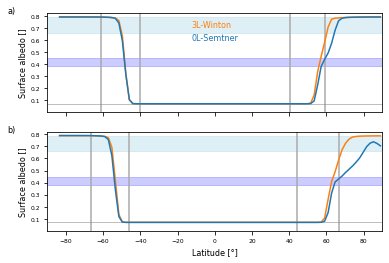

In [7]:
fig, ax = plt.subplots(2,1,figsize=(6,4),sharex=True,sharey=True)
month_name=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
axcount=0;
labelsize=8
ticksize=6
for ind in [1,0]:
    albedo_Wzm = get_albedo(winton_zmsimarray[ind])
    albedo_Szm = get_albedo(semtner_zmsimarray[ind])

    albedo_W = get_albedo(winton_simarray[ind])
    albedo_S = get_albedo(semtner_simarray[ind])

    SW_out_W = get_var(winton_simarray[ind],"rsuscs", True) 
    SW_out_S = get_var(semtner_simarray[ind],"rsuscs", True) 

    monmean_Wzm=albedo_Wzm.where(albedo_Wzm['time.year'] >= albedo_Wzm['time.year'][-40*12], drop=True).groupby('time.month').mean(dim='time')
    monmean_Szm=albedo_Szm.where(albedo_Szm['time.year'] >= albedo_Szm['time.year'][-40*12], drop=True).groupby('time.month').mean(dim='time')

    monmean_W=albedo_W.where(albedo_W['time.year'] >= albedo_W['time.year'][-40*12], drop=True).groupby('time.month').mean(dim='time')
    monmean_S=albedo_S.where(albedo_S['time.year'] >= albedo_S['time.year'][-40*12], drop=True).groupby('time.month').mean(dim='time')

    SW_outmonmean_W=SW_out_W.where(SW_out_W['time.year'] >= SW_out_W['time.year'][-40*12], drop=True).groupby('time.month').mean(dim='time')
    SW_outmonmean_S=SW_out_S.where(SW_out_S['time.year'] >= SW_out_S['time.year'][-40*12], drop=True).groupby('time.month').mean(dim='time')

    ax[axcount].vlines(timemean_sicS["lat"][[Nmin_iceborderS[ind], Smin_iceborderS[ind]]],0,400,color='darkgray', alpha=1)
    ax[axcount].vlines(timemean_sicS["lat"][[Nmax_iceborderS[ind], Smax_iceborderS[ind]]],0,400,color='darkgray', alpha=1)

    month = 8
    rect_snow=mpl.patches.Rectangle((-90,albsnow_warm),180,albsnow_cold-albsnow_warm, alpha=0.4, color='lightblue')
    rect_ice=mpl.patches.Rectangle((-90,albice_warm),180,albice_cold-albice_warm, alpha=0.2, color='blue')
    ax[axcount].hlines(albocean,-90,90,linewidth=1,color='grey',alpha=0.5)
    ax[axcount].add_patch(rect_snow)
    ax[axcount].add_patch(rect_ice)
    lW=ax[axcount].plot(monmean_Wzm['lat'],monmean_Wzm.sel(month=month),c='C1',label='Winton')
    lS=ax[axcount].plot(monmean_Szm['lat'],monmean_Szm.sel(month=month),c='C0',label='Semtner')
    print("axis " +str(axcount) +": " +winton_exparray[ind] +" and " +semtner_exparray[ind])
    #ax[axcount].annotate(month_name[month-1],(0,0.55),horizontalalignment='center')
    axcount+=1;
#ax.annotate(equivalent_co2_factor((SW_outmonmean_W.sel(month=month)-SW_outmonmean_S.sel(month=month)).values).round(3),(40,0.37),horizontalalignment='center',verticalalignment='top')
ax[1].set_xlim(-90,90)
ax[1].set_ylim(0,0.82)
ax[1].set_yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
lgd = legend_color(ax[0],['3L-Winton', '0L-Semtner'],9, labelsize)
ax[1].set_xlabel('Latitude [°]', fontsize=labelsize)
ax[0].set_ylabel('Surface albedo []', fontsize=labelsize)
ax[1].set_ylabel('Surface albedo []', fontsize=labelsize)
ax[0].tick_params(labelsize=ticksize) 
ax[1].tick_params(labelsize=ticksize) 
#fig.suptitle('monthly mean zonal mean surface albedo over the last 40 years\n' +winton_exparray[ind] +' & ' +semtner_exparray[ind])
#plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9, wspace=0.05, hspace=0.1)

ax[0].text(-0.12,1,"a)", transform=ax[0].transAxes, fontsize=labelsize)
ax[1].text(-0.12,1,"b)", transform=ax[1].transAxes, fontsize=labelsize)

plt.savefig("plots/surface_albedo_July_multi.pdf",dpi=500)
#plt.show()

mlo_aqua_2437ppmv_winton and mlo_aqua_1688ppmv_hice_unlim


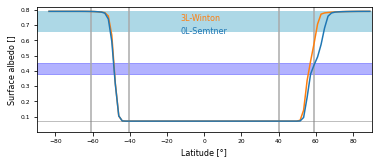

In [8]:
fig, ax = plt.subplots(1,1,figsize=(6,2.3))
month_name=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
axcount=0;
ind=1
albedo_Wzm = get_albedo(winton_zmsimarray[ind])
albedo_Szm = get_albedo(semtner_zmsimarray[ind])

albedo_W = get_albedo(winton_simarray[ind])
albedo_S = get_albedo(semtner_simarray[ind])

SW_out_W = get_var(winton_simarray[ind],"rsuscs", True) 
SW_out_S = get_var(semtner_simarray[ind],"rsuscs", True) 

monmean_Wzm=albedo_Wzm.where(albedo_Wzm['time.year'] >= albedo_Wzm['time.year'][-40*12], drop=True).groupby('time.month').mean(dim='time')
monmean_Szm=albedo_Szm.where(albedo_Szm['time.year'] >= albedo_Szm['time.year'][-40*12], drop=True).groupby('time.month').mean(dim='time')

monmean_W=albedo_W.where(albedo_W['time.year'] >= albedo_W['time.year'][-40*12], drop=True).groupby('time.month').mean(dim='time')
monmean_S=albedo_S.where(albedo_S['time.year'] >= albedo_S['time.year'][-40*12], drop=True).groupby('time.month').mean(dim='time')

SW_outmonmean_W=SW_out_W.where(SW_out_W['time.year'] >= SW_out_W['time.year'][-40*12], drop=True).groupby('time.month').mean(dim='time')
SW_outmonmean_S=SW_out_S.where(SW_out_S['time.year'] >= SW_out_S['time.year'][-40*12], drop=True).groupby('time.month').mean(dim='time')

ax.vlines(timemean_sicS["lat"][[Nmin_iceborderS[ind], Smin_iceborderS[ind]]],0,400,color='darkgray', alpha=1)
ax.vlines(timemean_sicS["lat"][[Nmax_iceborderS[ind], Smax_iceborderS[ind]]],0,400,color='darkgray', alpha=1)

month = 8
rect_snow=mpl.patches.Rectangle((-90,albsnow_warm),180,albsnow_cold-albsnow_warm, alpha=1, color='lightblue')
rect_ice=mpl.patches.Rectangle((-90,albice_warm),180,albice_cold-albice_warm, alpha=0.3, color='blue')
ax.hlines(albocean,-90,90,linewidth=1,color='grey',alpha=0.5)
ax.add_patch(rect_snow)
ax.add_patch(rect_ice)
lW=ax.plot(monmean_Wzm['lat'],monmean_Wzm.sel(month=month),c='C1',label='Winton')
lS=ax.plot(monmean_Szm['lat'],monmean_Szm.sel(month=month),c='C0',label='Semtner')
print(winton_exparray[ind] +" and " +semtner_exparray[ind])
#ax[axcount].annotate(month_name[month-1],(0,0.55),horizontalalignment='center')

#ax.annotate(equivalent_co2_factor((SW_outmonmean_W.sel(month=month)-SW_outmonmean_S.sel(month=month)).values).round(3),(40,0.37),horizontalalignment='center',verticalalignment='top')
ax.set_xlim(-90,90)
ax.set_ylim(0,0.82)
ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
lgd = legend_color(ax,['3L-Winton', '0L-Semtner'],9,labelsize)
ax.set_xlabel('Latitude [°]',fontsize=labelsize)
ax.set_ylabel('Surface albedo []',fontsize=labelsize)
ax.tick_params(labelsize=ticksize) 

#fig.suptitle('monthly mean zonal mean surface albedo over the last 40 years\n' +winton_exparray[ind] +' & ' +semtner_exparray[ind])
#plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9, wspace=0.05, hspace=0.1)
plt.savefig("plots/surface_albedo_July_rev1.pdf",bbox_inches="tight")

In [9]:
import csv
## get components of TOA energy balance

fieldnames=["simulation", "SW in", "SW out", "LW out"]
f = open("plots/TOA_balance.csv", 'w')
writer = csv.writer(f)
writer.writerow(["simulation", "SW in", "SW out", "LW out", "SW cs out", "LW cs out"])
for ind in [1,0]:
    
    SW_in_W = get_var(winton_simarray[ind],"rsdt", True) 
    SW_in_S = get_var(semtner_simarray[ind],"rsdt", True)   
    SW_inmean_W=seltimemean(SW_in_W, 40).values
    SW_inmean_S=seltimemean(SW_in_S, 40).values
    
    SW_out_W = get_var(winton_simarray[ind],"rsut", True) 
    SW_out_S = get_var(semtner_simarray[ind],"rsut", True)   
    SW_outmean_W=seltimemean(SW_out_W, 40).values
    SW_outmean_S=seltimemean(SW_out_S, 40).values
    
    LW_out_W = get_var(winton_simarray[ind],"rlut", True) 
    LW_out_S = get_var(semtner_simarray[ind],"rlut", True)   
    LW_outmean_W=seltimemean(LW_out_W, 40).values
    LW_outmean_S=seltimemean(LW_out_S, 40).values
    
    SWcs_out_W = get_var(winton_simarray[ind],"rsutcs", True) 
    SWcs_out_S = get_var(semtner_simarray[ind],"rsutcs", True)   
    SWcs_outmean_W=seltimemean(SWcs_out_W, 40).values
    SWcs_outmean_S=seltimemean(SWcs_out_S, 40).values
    
    LWcs_out_W = get_var(winton_simarray[ind],"rlutcs", True) 
    LWcs_out_S = get_var(semtner_simarray[ind],"rlutcs", True)   
    LWcs_outmean_W=seltimemean(LWcs_out_W, 40).values
    LWcs_outmean_S=seltimemean(LWcs_out_S, 40).values
    
    
    
    
    print(winton_exparray[ind] +": " +" SWin="+str(SW_inmean_W) +" SWout="+str(SW_outmean_W) +"; LWout=" +str(LW_outmean_W) +"; total=" +str(SW_inmean_W-SW_outmean_W-LW_outmean_W))
    print(semtner_exparray[ind] +": " +" SWin="+str(SW_inmean_S) +" SWout="+str(SW_outmean_S) +"; LWout=" +str(LW_outmean_S)+"; total=" +str(SW_inmean_S-SW_outmean_S-LW_outmean_S))
    print("")
    
    
    writer.writerow([winton_exparray[ind], str(SW_inmean_W), str(SW_outmean_W), str(LW_outmean_W), str(SWcs_outmean_W), str(LWcs_outmean_W)])
    writer.writerow([semtner_exparray[ind], str(SW_inmean_S), str(SW_outmean_S), str(LW_outmean_S), str(SWcs_outmean_S), str(LWcs_outmean_S)])
    
f.close()


mlo_aqua_2437ppmv_winton:  SWin=321.23425 SWout=98.25365; LWout=222.16487; total=0.81573486
mlo_aqua_1688ppmv_hice_unlim:  SWin=321.23425 SWout=97.2439; LWout=223.32451; total=0.6658478

mlo_aqua_3000ppmv_winton:  SWin=321.23425 SWout=94.45228; LWout=225.86537; total=0.9166107
mlo_aqua_2250ppmv_hice_unlim:  SWin=321.23425 SWout=93.05864; LWout=227.3154; total=0.86021423



clear sky:
637.0255380792839 PW; 1.2489118006869346 W/m^2 = 1.2489128 W/m^2
0.23056602641189058
0.8042223095666693
-0.03478833597856455
all sky:
515.034057095216 PW; 1.0097430530043008 W/m^2 = 1.0097504 W/m^2
0.16410614491583508
0.709068870009622
0.12682498507453116


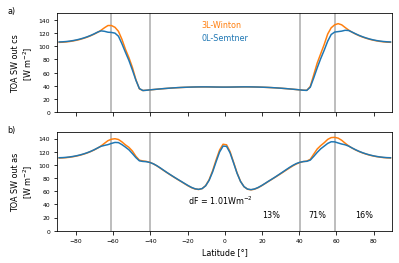

mlo_aqua_2437ppmv_winton
mlo_aqua_1688ppmv_hice_unlim


In [10]:
fig, ax = plt.subplots(2,1,figsize=(6,4),sharex=True, sharey = True)



labelsize=8
ticksize=6

nyears = 40



dN1=np.zeros(3)
dN2=np.zeros(3)
dE=np.zeros(3)
dglob=np.zeros(3)

ind=1
for sky_ind in range(2):
    SW_out_W_cs = get_var(winton_zmsimarray[ind],"rsutcs", True) 
    SW_out_S_cs = get_var(semtner_zmsimarray[ind],"rsutcs", True)

    LW_out_W_cs = get_var(winton_zmsimarray[ind],"rlutcs", True) 
    LW_out_S_cs = get_var(semtner_zmsimarray[ind],"rlutcs", True)

    SW_out_W = get_var(winton_zmsimarray[ind],"rsut", True) 
    SW_out_S = get_var(semtner_zmsimarray[ind],"rsut", True)

    SW_in_W = get_var(winton_zmsimarray[ind],"rsdt", True) 
    SW_in_S = get_var(semtner_zmsimarray[ind],"rsdt", True) 

    LW_out_W = get_var(winton_zmsimarray[ind],"rlut", True) 
    LW_out_S = get_var(semtner_zmsimarray[ind],"rlut", True)


    timemean_SWinW = seltimemean(SW_in_W, nyears)
    timemean_SWinS = seltimemean(SW_in_S, nyears)
    timemean_SWoutW_cs = seltimemean(SW_out_W_cs, nyears)
    timemean_SWoutS_cs = seltimemean(SW_out_S_cs, nyears)
    timemean_LWoutW_cs = seltimemean(LW_out_W_cs, nyears)
    timemean_LWoutS_cs = seltimemean(LW_out_S_cs, nyears)
    timemean_SWoutW = seltimemean(SW_out_W, nyears)
    timemean_SWoutS = seltimemean(SW_out_S, nyears)
    timemean_LWoutW = seltimemean(LW_out_W, nyears)
    timemean_LWoutS = seltimemean(LW_out_S, nyears)

    SW_out_W_integrated = integrate_zonal_data(timemean_SWoutW,timemean_SWoutW.lat)
    SW_out_S_integrated = integrate_zonal_data(timemean_SWoutS,timemean_SWoutS.lat)
    SW_out_W_cs_integrated = integrate_zonal_data(timemean_SWoutW_cs,timemean_SWoutW_cs.lat)
    SW_out_S_cs_integrated = integrate_zonal_data(timemean_SWoutS_cs,timemean_SWoutS_cs.lat)
    
    
    if sky_ind==0:
        N1_W = SW_out_W_cs_integrated[0:Nmin_iceborderS[ind]].sum()
        N2_W = SW_out_W_cs_integrated[Nmin_iceborderS[ind]:Nmax_iceborderS[ind]].sum()
        E_W = SW_out_W_cs_integrated[Nmax_iceborderS[ind]:Smax_iceborderS[ind]+1].sum()
        S2_W = SW_out_W_cs_integrated[Smax_iceborderS[ind]+1:Smin_iceborderS[ind]+1].sum()
        S1_W = SW_out_W_cs_integrated[Smin_iceborderS[ind]+1:].sum()

        N1_S = SW_out_S_cs_integrated[0:Nmin_iceborderS[ind]].sum()
        N2_S = SW_out_S_cs_integrated[Nmin_iceborderS[ind]:Nmax_iceborderS[ind]].sum()
        E_S = SW_out_S_cs_integrated[Nmax_iceborderS[ind]:Smax_iceborderS[ind]+1].sum()
        S2_S = SW_out_S_cs_integrated[Smax_iceborderS[ind]+1:Smin_iceborderS[ind]+1].sum()
        S1_S = SW_out_S_cs_integrated[Smin_iceborderS[ind]+1:].sum()
        
        dglob[sky_ind] = SW_out_W_cs_integrated.sum()-SW_out_S_cs_integrated.sum()
    elif sky_ind==1:
        N1_W = SW_out_W_integrated[0:Nmin_iceborderS[ind]].sum()
        N2_W = SW_out_W_integrated[Nmin_iceborderS[ind]:Nmax_iceborderS[ind]].sum()
        E_W = SW_out_W_integrated[Nmax_iceborderS[ind]:Smax_iceborderS[ind]+1].sum()
        S2_W = SW_out_W_integrated[Smax_iceborderS[ind]+1:Smin_iceborderS[ind]+1].sum()
        S1_W = SW_out_W_integrated[Smin_iceborderS[ind]+1:].sum()

        N1_S = SW_out_S_integrated[0:Nmin_iceborderS[ind]].sum()
        N2_S = SW_out_S_integrated[Nmin_iceborderS[ind]:Nmax_iceborderS[ind]].sum()
        E_S = SW_out_S_integrated[Nmax_iceborderS[ind]:Smax_iceborderS[ind]+1].sum()
        S2_S = SW_out_S_integrated[Smax_iceborderS[ind]+1:Smin_iceborderS[ind]+1].sum()
        S1_S = SW_out_S_integrated[Smin_iceborderS[ind]+1:].sum()
        
        dglob[sky_ind] = SW_out_W_integrated.sum()-SW_out_S_integrated.sum()
        
    dN1[sky_ind] = (N1_W.values+S1_W.values) - (N1_S.values+S1_S.values)
    dN2[sky_ind] = (N2_W.values+S2_W.values) - (N2_S.values+S2_S.values)
    dE[sky_ind] = E_W.values - E_S.values
    

    
    
    #areas
    NA1 = -2*np.pi*6371000**2 * (1-np.cos(np.deg2rad(SW_out_W_integrated.lat[ind]+90))) + 2*np.pi*6371000**2 * (1-np.cos(np.deg2rad(SW_out_W_integrated.lat[Nmin_iceborderS[ind]]+90)))
    NA2 = -2*np.pi*6371000**2 * (1-np.cos(np.deg2rad(SW_out_W_integrated.lat[Nmin_iceborderS[ind]]+90))) + 2*np.pi*6371000**2 * (1-np.cos(np.deg2rad(SW_out_W_integrated.lat[Nmax_iceborderS[ind]]+90)))
    E = -2*np.pi*6371000**2 * (1-np.cos(np.deg2rad(SW_out_W_integrated.lat[Nmax_iceborderS[ind]]+90))) + 2*np.pi*6371000**2 * (1-np.cos(np.deg2rad(SW_out_W_integrated.lat[Smax_iceborderS[ind]+1]+90)))
    SA2 = -2*np.pi*6371000**2 * (1-np.cos(np.deg2rad(SW_out_W_integrated.lat[Smax_iceborderS[ind]+1]+90))) + 2*np.pi*6371000**2 * (1-np.cos(np.deg2rad(SW_out_W_integrated.lat[Smin_iceborderS[ind]+1]+90)))
    SA1 = -2*np.pi*6371000**2 * (1-np.cos(np.deg2rad(SW_out_W_integrated.lat[Smin_iceborderS[ind]+1]+90))) + 2*np.pi*6371000**2 * (1-np.cos(np.deg2rad(SW_out_W_integrated.lat[Smin_iceborderS[ind]+1]+90)))
    
    
    if sky_ind!=2:
        ax[sky_ind].vlines(timemean_sicS["lat"][[Nmin_iceborderS[ind], Smin_iceborderS[ind]]],0,400,color='darkgray', alpha=1)
        ax[sky_ind].vlines(timemean_sicS["lat"][[Nmax_iceborderS[ind], Smax_iceborderS[ind]]],0,400,color='darkgray', alpha=1)
    else:
        ax[sky_ind].vlines(timemean_sicS["lat"][[Nmin_iceborderS[ind], Smin_iceborderS[ind]]],-200,200,color='darkgray', alpha=1)
        ax[sky_ind].vlines(timemean_sicS["lat"][[Nmax_iceborderS[ind], Smax_iceborderS[ind]]],-200,200,color='darkgray', alpha=1)
    
    if sky_ind== 0:
        lW_SW=ax[sky_ind].plot(timemean_SWoutW_cs['lat'],timemean_SWoutW_cs,c='C1',label='Winton')
        lS_SW=ax[sky_ind].plot(timemean_SWoutS_cs['lat'],timemean_SWoutS_cs,c='C0',label='Semtner')
    elif sky_ind==1:
        lW_SW=ax[sky_ind].plot(timemean_SWoutW['lat'],timemean_SWoutW,c='C1',label='Winton')
        lS_SW=ax[sky_ind].plot(timemean_SWoutS['lat'],timemean_SWoutS,c='C0',label='Semtner')
    elif sky_ind==2:
        lW_SW=ax[sky_ind].plot(timemean_SWoutW['lat'],-1 * (timemean_SWoutW_cs-timemean_SWoutW),c='C1',label='Winton')
        lS_SW=ax[sky_ind].plot(timemean_SWoutS['lat'],-1 * (timemean_SWoutS_cs-timemean_SWoutS),c='C0',label='Semtner')
        
    if sky_ind==0:
        print("clear sky:")
        total = selmean(get_var(winton_simarray[ind],"rsutcs", True), nyears) - selmean(get_var(semtner_simarray[ind],"rsutcs", True), nyears)
    else:
        print("all sky:")
        total = selmean(get_var(winton_simarray[ind],"rsut", True), nyears) - selmean(get_var(semtner_simarray[ind],"rsut", True), nyears)
        
    print(str(dglob[sky_ind]*1e-12) +" PW; " +str(dglob[sky_ind]/(4 * np.pi *6371000**2)) +" W/m^2 = " +str(total.values)+" W/m^2" )
    print(dN1[sky_ind] / dglob[sky_ind])
    print(dN2[sky_ind] / dglob[sky_ind])
    print(dE[sky_ind] / dglob[sky_ind])
        
ax[0].set_xlim(-90,90)
ax[1].set_xlim(-90,90)
ax[0].set_ylim(0,150)
legend_color(ax[0],['3L-Winton', '0L-Semtner'],9, labelsize)
ax[1].set_xlabel('Latitude [°]', fontsize=labelsize)
ax[0].set_ylabel('TOA SW out cs\n[W m$^{-2}$]', fontsize=labelsize)
ax[1].set_ylabel('TOA SW out as\n[W m$^{-2}$]', fontsize=labelsize)
#ax[2].set_ylabel('CRE [W m$^{-2}$]')
ax[1].annotate("dF = " +str(round(total.values.tolist(),2)) +"Wm$^{-2}$",(-20,40), fontsize=labelsize) # 1.01 Wm$^{-2}$")
ax[1].annotate(f'{100*round(dN1[sky_ind] / dglob[sky_ind],2):.0f}' +"%",(70,20), fontsize=labelsize)
ax[1].annotate(f'{100*round(dN2[sky_ind] / dglob[sky_ind],2):.0f}' +"%",(45,20), fontsize=labelsize)
ax[1].annotate(f'{100*round(dE[sky_ind] / dglob[sky_ind],2):.0f}' +"%",(20,20), fontsize=labelsize)

#ax[1].annotate("dF = 1.01 Wm$^{-2}$",(-20,40))
#ax[1].annotate("16%",(70,20))
#ax[1].annotate("71%",(45,20))
#ax[1].annotate("13%",(20,20))

#ax[0].annotate("dF = 1.25 Wm$^{-2}$",(-20,50))
#ax[0].annotate("23%",(70,20))
#ax[0].annotate("80%",(45,20))
#ax[0].annotate("-3%",(20,20))

ax[0].text(-0.15,1,"a)", transform=ax[0].transAxes, fontsize=labelsize)
ax[1].text(-0.15,1,"b)", transform=ax[1].transAxes, fontsize=labelsize)
ax[0].tick_params(labelsize=ticksize) 
ax[1].tick_params(labelsize=ticksize) 

plt.savefig("plots/TOA_EB.pdf")
plt.savefig("plots/TOA_EB.png", dpi=500)
plt.show()
print(winton_exparray[ind])
print(semtner_exparray[ind])

In [11]:
print(winton_exparray[ind] +" and " +semtner_exparray[ind])
for sky_ind in range(2):
    if sky_ind==0:
        print("clear sky:")
        total = selmean(get_var(winton_simarray[ind],"rsutcs", True), 40) - selmean(get_var(semtner_simarray[ind],"rsutcs", True), 40)
    else:
        print("all sky:")
        total = selmean(get_var(winton_simarray[ind],"rsut", True), 40) - selmean(get_var(semtner_simarray[ind],"rsut", True), 40)
        
    print(str(dglob[sky_ind]*1e-12) +" PW; " +str(dglob[sky_ind]/(4 * np.pi *6371000**2)) +" W/m^2 = " +str(total.values)+" W/m^2" )
    print(dN1[sky_ind] / dglob[sky_ind])
    print(dN2[sky_ind] / dglob[sky_ind])
    print(dE[sky_ind] / dglob[sky_ind])


mlo_aqua_2437ppmv_winton and mlo_aqua_1688ppmv_hice_unlim
clear sky:
637.0255380792839 PW; 1.2489118006869346 W/m^2 = 1.2489128 W/m^2
0.23056602641189058
0.8042223095666693
-0.03478833597856455
all sky:
515.034057095216 PW; 1.0097430530043008 W/m^2 = 1.0097504 W/m^2
0.16410614491583508
0.709068870009622
0.12682498507453116


Text(0.5, 0, 'latitude [°]')

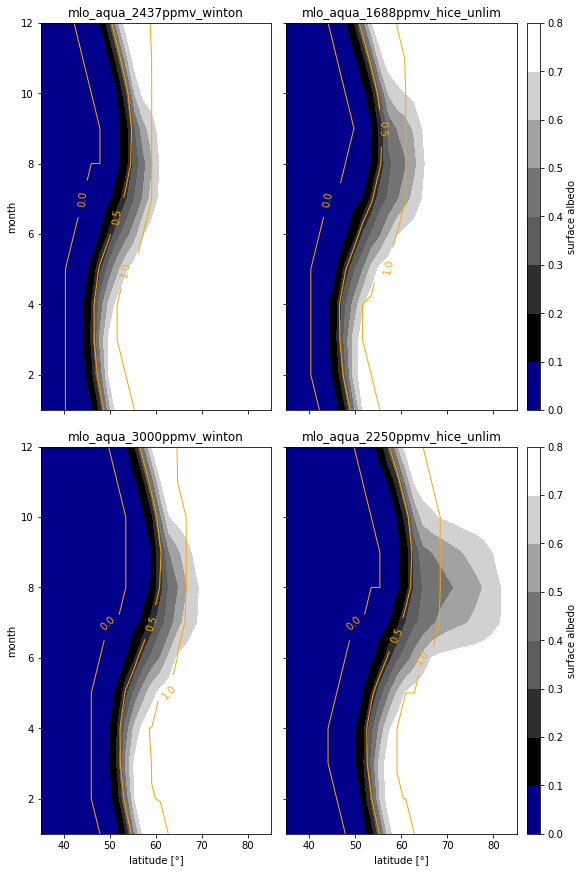

In [12]:
# hovmoeller plots of reflected sw radiation
fig, ax = plt.subplots(2,2,figsize=(8,12), sharey = True, sharex = True, constrained_layout=True)
axind=0

colors1 = np.linspace(0.0, 1.0, 12)
colors = np.append("darkblue",colors1.astype("str"))

#ticks=[0,0.01, 0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,10,20]
ticks=[0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]

cmap= mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(ticks, cmap.N)


for ind in [1,0]:
    albedo_Wzm = get_albedo(winton_zmsimarray[ind])
    albedo_Szm = get_albedo(semtner_zmsimarray[ind])
    
    sic_Wzm = get_var(winton_zmsimarray[ind], "sic")
    sic_Szm = get_var(semtner_zmsimarray[ind], "sic")
    
    albedo_Wzmmean = selmonmean(albedo_Wzm, 40)
    albedo_Szmmean = selmonmean(albedo_Szm, 40)
    sic_Wzmmean = selmonmean(sic_Wzm, 40)
    sic_Szmmean = selmonmean(sic_Szm, 40)
    
    f1 = ax[axind,0].contourf(albedo_Wzmmean.lat,albedo_Wzmmean.month, albedo_Wzmmean,levels = ticks,cmap= cmap,norm=norm)
    f2 = ax[axind,1].contourf(albedo_Szmmean.lat,albedo_Szmmean.month, albedo_Szmmean,levels = ticks,cmap= cmap,norm=norm)
    
    c1 = ax[axind,0].contour(sic_Wzmmean.lat,sic_Wzmmean.month, sic_Wzmmean, levels=[0,0.5,0.999999],colors="orange",linewidths=1)
    c2 = ax[axind,1].contour(sic_Szmmean.lat,sic_Szmmean.month, sic_Szmmean, levels=[0,0.5,0.999999],colors="orange",linewidths=1)
    plt.clabel(c1,fmt='%1.1f',colors="orange")
    plt.clabel(c2,fmt='%1.1f',colors="orange")
    
    ax[axind,0].set_xlim(35,85)
    ax[axind,0].set_title(winton_exparray[ind])
    ax[axind,1].set_title(semtner_exparray[ind])
    cbar = plt.colorbar(f2,ax=ax[axind,1])
    cbar.set_label("surface albedo")
    axind+=1
ax[0,0].set_ylabel("month")
ax[1,0].set_ylabel("month")
ax[1,0].set_xlabel("latitude [°]")
ax[1,1].set_xlabel("latitude [°]")

Text(0.5, 0, 'latitude [°]')

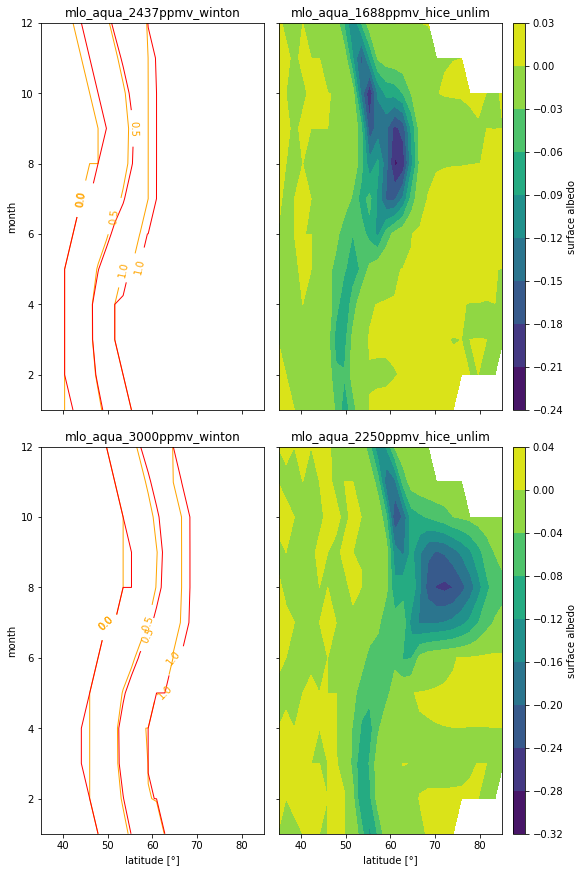

In [13]:
# hovmoeller plots of albedo
fig, ax = plt.subplots(2,2,figsize=(8,12), sharey = True, sharex = True, constrained_layout=True)
axind=0

colors1 = np.linspace(0.0, 1.0, 12)
colors = np.append("darkblue",colors1.astype("str"))

#ticks=[0,0.01, 0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,10,20]
ticks=[0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]

cmap= mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(ticks, cmap.N)


for ind in [1,0]:
    albedo_Wzm = get_albedo(winton_zmsimarray[ind])
    albedo_Szm = get_albedo(semtner_zmsimarray[ind])
    
    sic_Wzm = get_var(winton_zmsimarray[ind], "sic")
    sic_Szm = get_var(semtner_zmsimarray[ind], "sic")
    
    rsutcs_Wzm = get_var(winton_zmsimarray[ind], "rsutcs")
    rsutcs_Szm = get_var(semtner_zmsimarray[ind], "rsutcs")
    
    albedo_Wzmmean = selmonmean(albedo_Wzm, 40)
    albedo_Szmmean = selmonmean(albedo_Szm, 40)
    sic_Wzmmean = selmonmean(sic_Wzm, 40)
    sic_Szmmean = selmonmean(sic_Szm, 40)
    rsutcs_Wzmmean = selmonmean(rsutcs_Wzm, 40)
    rsutcs_Szmmean = selmonmean(rsutcs_Szm, 40)
    
    #f1 = ax[axind,0].contourf(albedo_Wzmmean.lat,albedo_Wzmmean.month, albedo_Wzmmean,levels = ticks,cmap= cmap,norm=norm)
    f2 = ax[axind,1].contourf(albedo_Szmmean.lat,albedo_Szmmean.month, albedo_Szmmean-albedo_Wzmmean)
    
    c1 = ax[axind,0].contour(sic_Wzmmean.lat,sic_Wzmmean.month, sic_Wzmmean, levels=[0,0.5,0.999999],colors="orange",linewidths=1)
    c2 = ax[axind,0].contour(sic_Szmmean.lat,sic_Szmmean.month, sic_Szmmean, levels=[0,0.5,0.999999],colors="red",linewidths=1)
    plt.clabel(c1,fmt='%1.1f',colors="orange")
    plt.clabel(c2,fmt='%1.1f',colors="orange")
    
    ax[axind,0].set_xlim(35,85)
    ax[axind,0].set_title(winton_exparray[ind])
    ax[axind,1].set_title(semtner_exparray[ind])
    cbar = plt.colorbar(f2,ax=ax[axind,1])
    cbar.set_label("surface albedo")
    axind+=1
ax[0,0].set_ylabel("month")
ax[1,0].set_ylabel("month")
ax[1,0].set_xlabel("latitude [°]")
ax[1,1].set_xlabel("latitude [°]")
    

[-70. -65. -60. -55. -50. -45. -40. -35. -30. -25. -20. -15. -10.  -5.
   0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.]


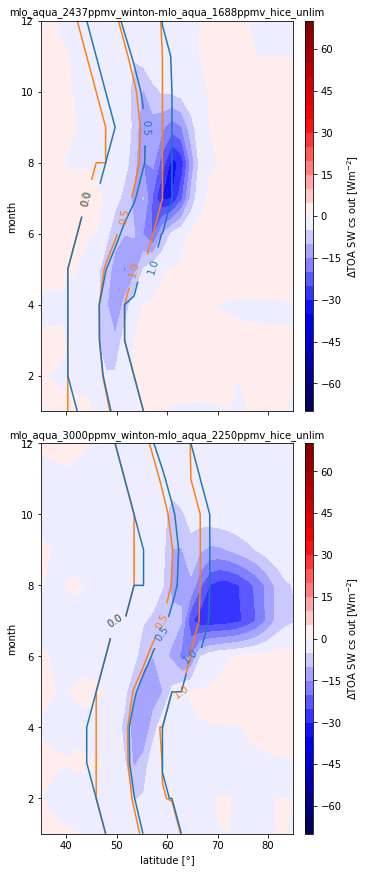

In [14]:
# hovmoeller plots of reflected sw radiation
from matplotlib.colors import LinearSegmentedColormap
fig, ax = plt.subplots(2,1,figsize=(5,12), sharey = True, sharex = True, constrained_layout=True)
axind=0

cmap1 = plt.get_cmap("Reds")
cmap2 = plt.get_cmap("Blues_r")

cmap = LinearSegmentedColormap.from_list("", colors, N=12)
ticks=np.linspace(-70,70,29)
print(ticks)

for ind in [1,0]:
    albedo_Wzm = get_albedo(winton_zmsimarray[ind])
    albedo_Szm = get_albedo(semtner_zmsimarray[ind])
    
    sic_Wzm = get_var(winton_zmsimarray[ind], "sic")
    sic_Szm = get_var(semtner_zmsimarray[ind], "sic")
    
    rsutcs_Wzm = get_var(winton_zmsimarray[ind], "rsut")
    rsutcs_Szm = get_var(semtner_zmsimarray[ind], "rsut")
    
    albedo_Wzmmean = selmonmean(albedo_Wzm, 40)
    albedo_Szmmean = selmonmean(albedo_Szm, 40)
    sic_Wzmmean = selmonmean(sic_Wzm, 40)
    sic_Szmmean = selmonmean(sic_Szm, 40)
    rsutcs_Wzmmean = selmonmean(rsutcs_Wzm, 40)
    rsutcs_Szmmean = selmonmean(rsutcs_Szm, 40)
    
    #f1 = ax[axind,0].contourf(rsutcs_Wzmmean.lat,rsutcs_Wzmmean.month, rsutcs_Wzmmean, levels=ticks)
    f2 = ax[axind].contourf(rsutcs_Szmmean.lat,rsutcs_Szmmean.month, rsutcs_Szmmean-rsutcs_Wzmmean, levels=ticks,cmap="seismic")
    
    c1 = ax[axind].contour(sic_Wzmmean.lat,sic_Wzmmean.month, sic_Wzmmean, levels=[0,0.5,0.999999],colors="C1",linewidths=1.5)
    c2 = ax[axind].contour(sic_Szmmean.lat,sic_Szmmean.month, sic_Szmmean, levels=[0,0.5,0.999999],colors="C0",linewidths=1.5)
    plt.clabel(c1,fmt='%1.1f',colors="C1")
    plt.clabel(c2,fmt='%1.1f',colors="C0")
    
    ax[axind].set_xlim(35,85)
    ax[axind].set_title(str(winton_exparray[ind]) +"-" +str(semtner_exparray[ind]),fontdict={'size': 10})
    cbar = plt.colorbar(f2,ax=ax[axind])
    cbar.set_label("$\Delta$TOA SW cs out [Wm$^{-2}$]")
    axind+=1
ax[0].set_ylabel("month")
ax[1].set_ylabel("month")
ax[1].set_xlabel("latitude [°]")
ax[1].set_xlabel("latitude [°]")
plt.savefig("plots/hovmoeller_rsutcs_multi.png",dpi=300)

Text(0.5, 0, 'latitude [°]')

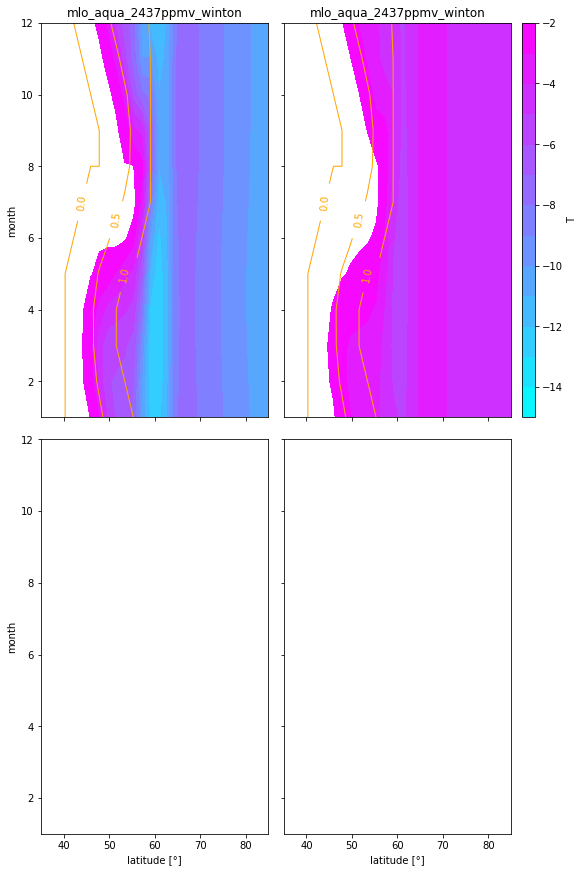

In [15]:
# hovmoeller plots of ice temperatures
fig, ax = plt.subplots(2,2,figsize=(8,12), sharey = True, sharex = True, constrained_layout=True)
axind=0

colors1 = np.linspace(0.0, 1.0, 12)
colors = np.append("darkblue",colors1.astype("str"))

#ticks=[0,0.01, 0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,10,20]
ticks=np.linspace(-15,-2,14)

cmap= "cool"


for ind in [1]:
    T1_Wzm = get_var(winton_zmsimarray[ind],'t1_icecl')
    T2_Wzm = get_var(winton_zmsimarray[ind],'t2_icecl')
    
    sic_Wzm = get_var(winton_zmsimarray[ind], "sic")
    
    T1_Wzmmean = selmonmean(T1_Wzm, 40)
    T2_Wzmmean = selmonmean(T2_Wzm, 40)
    sic_Wzmmean = selmonmean(sic_Wzm, 40)
    
    f1 = ax[axind,0].contourf(T1_Wzmmean.lat,T1_Wzmmean.month, T1_Wzmmean,levels = ticks,cmap= cmap)
    f2 = ax[axind,1].contourf(T2_Wzmmean.lat,T2_Wzmmean.month, T2_Wzmmean,levels = ticks,cmap= cmap)
    
    c1 = ax[axind,0].contour(sic_Wzmmean.lat,sic_Wzmmean.month, sic_Wzmmean, levels=[0,0.5,0.999999],colors="orange",linewidths=1)
    c2 = ax[axind,1].contour(sic_Wzmmean.lat,sic_Wzmmean.month, sic_Wzmmean, levels=[0,0.5,0.999999],colors="orange",linewidths=1)
    plt.clabel(c1,fmt='%1.1f',colors="orange")
    plt.clabel(c2,fmt='%1.1f',colors="orange")
    
    ax[axind,0].set_xlim(35,85)
    ax[axind,0].set_title(winton_exparray[ind])
    ax[axind,1].set_title(winton_exparray[ind])
    cbar = plt.colorbar(f2,ax=ax[axind,1])
    cbar.set_label("T")
    axind+=1
ax[0,0].set_ylabel("month")
ax[1,0].set_ylabel("month")
ax[1,0].set_xlabel("latitude [°]")
ax[1,1].set_xlabel("latitude [°]")

In [16]:
latind=79
print("lat= " +str(T1_Wzmmean[:,latind].lat.values))
print(T1_Wzmmean[:,latind].mean().values)
print(T1_Wzmmean[:,latind].min().values)
print(T1_Wzmmean[:,latind].max().values)

latind=74
print("lat= " +str(T1_Wzmmean[:,latind].lat.values))
print(T1_Wzmmean[:,latind].mean().values)
print(T1_Wzmmean[:,latind].min().values)
print(T1_Wzmmean[:,latind].max().values)


lat= 59.0625
-10.323657
-12.742918968200684
-7.017576694488525
lat= 49.6875
-3.1945837
-5.922392845153809
-1.8483264446258545


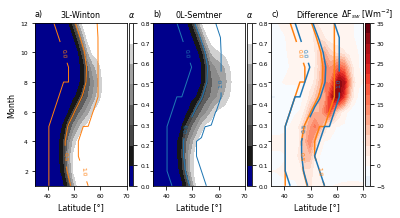

In [17]:
# hovmoeller plots of reflected sw radiation: Paper version
fig, ax = plt.subplots(1,3,figsize=(6,3), sharey = True, sharex = True)

labelsize=8
ticksize=6

ind=1
var="rsut"
ticks1=[0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
colors1 = np.linspace(0.0, 1.0, 12)
colors = np.append("darkblue",colors1.astype("str"))
cmap1= mpl.colors.ListedColormap(colors)


ticks2=np.linspace(-35,5,17)
reds = mpl.cm.get_cmap('Reds', np.size(ticks2)-3)
blues = mpl.cm.get_cmap('Blues_r', np.size(ticks2)-3)
newcolors2 = reds(np.linspace(0, 1, np.size(ticks2)-3))
newcolors = blues(np.linspace(0, 1, np.size(ticks2)-3))
newcolors = np.vstack((newcolors, newcolors2[:2,:]))

ticks2=np.linspace(-5,35,17)
reds = mpl.cm.get_cmap('Reds', np.size(ticks2)-3)
blues = mpl.cm.get_cmap('Blues_r', np.size(ticks2)-3)
newcolors2 = reds(np.linspace(0, 1, np.size(ticks2)-3))
newcolors = blues(np.linspace(0, 1, np.size(ticks2)-3))
newcolors = np.vstack((newcolors[-2:,:], newcolors2))

cmap2 = mpl.colors.ListedColormap(newcolors, name='newcmap')


albedo_Wzm = get_albedo(winton_zmsimarray[ind])
albedo_Szm = get_albedo(semtner_zmsimarray[ind])

sic_Wzm = get_var(winton_zmsimarray[ind], "sic")
sic_Szm = get_var(semtner_zmsimarray[ind], "sic")

var_Wzm = get_var(winton_zmsimarray[ind], var)
var_Szm = get_var(semtner_zmsimarray[ind], var)


albedo_Wzmmean = selmonmean(albedo_Wzm, 40)
albedo_Szmmean = selmonmean(albedo_Szm, 40)
sic_Wzmmean = selmonmean(sic_Wzm, 40)
sic_Szmmean = selmonmean(sic_Szm, 40)
var_Wzmmean = selmonmean(var_Wzm, 40)
var_Szmmean = selmonmean(var_Szm, 40)

f0 = ax[0].contourf(albedo_Wzmmean.lat,albedo_Wzmmean.month, albedo_Wzmmean,levels = ticks1,cmap= cmap1)
f1 = ax[1].contourf(albedo_Szmmean.lat,albedo_Szmmean.month, albedo_Szmmean,levels = ticks1,cmap= cmap1)
f2 = ax[2].contourf(var_Szmmean.lat,var_Szmmean.month, var_Wzmmean-var_Szmmean, levels=ticks2,cmap=cmap2)


divider = make_axes_locatable(ax[0])
cax0 = divider.new_horizontal(size='5%', pad=0.03)
fig.add_axes(cax0)
cbar0 = fig.colorbar(f0, cax = cax0, orientation = 'vertical')

divider = make_axes_locatable(ax[1])
cax1 = divider.new_horizontal(size='5%', pad=0.03)
fig.add_axes(cax1)
cbar1 = fig.colorbar(f1, cax = cax1, orientation = 'vertical')

divider = make_axes_locatable(ax[2])
cax2 = divider.new_horizontal(size='5%', pad=0.03)
fig.add_axes(cax2)
cbar2 = fig.colorbar(f2, cax = cax2, orientation = 'vertical')


c0 = ax[0].contour(sic_Wzmmean.lat,sic_Wzmmean.month, sic_Wzmmean, levels=[0,0.5,0.999999],colors="C1",linewidths=1)
c1 = ax[1].contour(sic_Szmmean.lat,sic_Szmmean.month, sic_Szmmean, levels=[0,0.5,0.999999],colors="C0",linewidths=1)

c21 = ax[2].contour(sic_Wzmmean.lat,sic_Wzmmean.month, sic_Wzmmean, levels=[0,0.5,0.999999999],colors="C1",linewidths=1.5)
c22 = ax[2].contour(sic_Szmmean.lat,sic_Szmmean.month, sic_Szmmean, levels=[0,0.5,0.999999999],colors="C0",linewidths=1.5)

plt.clabel(c21,fmt='%1.1f',colors="C1", fontsize=ticksize)
plt.clabel(c22,fmt='%1.1f',colors="C0", fontsize=ticksize)
plt.clabel(c0,fmt='%1.1f',colors="C1", fontsize=ticksize)
plt.clabel(c1,fmt='%1.1f',colors="C0", fontsize=ticksize)


cbar0.ax.set_title(r'$\alpha$', fontsize=labelsize)
cbar1.ax.set_title(r'$\alpha$', fontsize=labelsize)
cbar2.ax.set_title(r'$\Delta$F$_{sw}$ [Wm$^{-2}$]', fontsize=labelsize)


ax[0].set_title("3L-Winton", fontsize=labelsize)
ax[1].set_title("0L-Semtner", fontsize=labelsize)
ax[2].set_title("Difference", fontsize=labelsize)





cbar0.ax.tick_params(labelsize=ticksize) 
cbar1.ax.tick_params(labelsize=ticksize) 
cbar2.ax.tick_params(labelsize=ticksize) 
ax[0].tick_params(labelsize=ticksize) 
ax[1].tick_params(labelsize=ticksize) 
ax[2].tick_params(labelsize=ticksize) 



ax[0].set_xlim(35,70)

ax[0].set_ylabel("Month", fontsize=labelsize)
ax[0].set_xlabel("Latitude [°]", fontsize=labelsize)
ax[1].set_xlabel("Latitude [°]", fontsize=labelsize)
ax[2].set_xlabel("Latitude [°]", fontsize=labelsize)


ax[0].text(-0,1.04,"a)", transform=ax[0].transAxes, fontsize=labelsize)
ax[1].text(-0,1.04,"b)", transform=ax[1].transAxes, fontsize=labelsize)
ax[2].text(-0,1.04,"c)", transform=ax[2].transAxes, fontsize=labelsize)
plt.savefig("plots/hovmoeller_albedo_" +var +".png",dpi=300)
plt.savefig("plots/hovmoeller_albedo_" +var +".pdf")